# Trend-following

This notebook implements a few improvements that Baltas and Kosowski (2020) (BK2020, hereafter) propose to the time-series momentum strategy which originally appeared in Moskowitz et al (2012).

Note that like other notebooks, all backtests are performed by using a private library called `vivace`.

In [1]:
%matplotlib inline
from datetime import datetime
import logging
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
plt.style.use('bmh')

from vivace.backtest import signal
from vivace.backtest import processing
from vivace.backtest.contract import all_futures_baltas2020
from vivace.backtest.engine import BacktestEngine
from vivace.backtest.enums import Strategy, Weighting, RealisedVolatility
from vivace.backtest.stats import Performance

# Data

In [2]:
all_futures_baltas2020['name'].values

array(['WTI Crude Oil', 'Brent Crude Oil', 'Heating Oil', 'Natural Gas',
       'Gasoline', 'Copper', 'Gold', 'Palladium', 'Platinum', 'Silver',
       'Feeder Cattle', 'Live Cattle', 'Lean Hog', 'Corn', 'Oats',
       'Soybean Oil', 'Soybean Meal', 'Soybean', 'Wheat', 'Cocoa',
       'Coffee', 'Cotton', 'Lumber', 'Orange Juice', 'Sugar',
       'Australian Dollar', 'Canadian Dollar', 'Swiss Franc', 'Euro',
       'British Pound', 'Japanese Yen', 'E-Mini Nasdaq 100',
       'E-mini S&P 500', 'E-mini Russell 2000', 'FTSE 100', 'DAX',
       'CAC 40', 'IBEX 35', 'AEX', 'Swiss Market Index', 'SPI 200',
       'Topix', 'Hang Seng', 'US 2-year Treasury', 'US 5-year Treasury',
       'US 10-year Treasury', 'US treasury Bond', 'Germany Schatz',
       'Germany Bobl', 'Germany Bund', 'Germany Buxl', 'Gilt',
       'Canada 10-year Treasury', 'JGB'], dtype=object)

In [3]:
print(len(all_futures_baltas2020))

54


We try to use the same contract as the original paper where possible, resulting 54 futures contracts to analyse. The trading universe covers a wide range of asset classes and regions, and is made up of following instruments:
- Equity index futures
- Government bond futures
- FX futures
- Commodity futures

where the same trend detection method is applied.

# Performance


## Moskowitz et al

First we calculate the original trend-following portfolio with a more traditional close-to-close realised volatility estimator. Although Moskowitz et al uses the exponentially weighted standard deviation, BK2020 appears to compare against the rolling standard deviation.

In [4]:
engine_original = BacktestEngine(
    strategy=Strategy.DELTA_ONE.value,
    instrument=all_futures_baltas2020.index,
    signal=signal.ParallelSignal([
        signal.VolatilityScale(agg_method='rolling', window=21, ann_factor=261, 
                               target_volatility=0.4, signal_cap=0.95),
        signal.TSMOMMoskowitz2012(post_process=processing.AsFreq(freq='m', method='pad'))
    ], weighting='product'),
    weighting=Weighting.EQUAL_WEIGHT.value,
    log_level=logging.WARN,
)
engine_original.run()

In [5]:
engine_original_eq = (engine_original.calculate_equity_curve(calculate_net=False, rebalance_freq='m')
                      .rename('Trend-following portfolio (Moskowitz 2012)'))

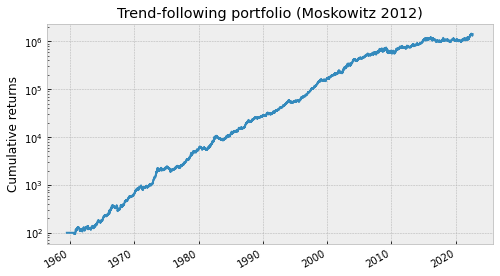

In [6]:
fig, ax = plt.subplots(figsize=(8, 4.5))
engine_original_eq.plot(ax=ax, logy=True)
ax.set_title('Trend-following portfolio (Moskowitz 2012)')
ax.set_ylabel('Cumulative returns');

In [7]:
engine_original_eq.pipe(Performance).summary()

,Trend-following portfolio (Moskowitz 2012)
CAGR,0.147960
Annualised vol,0.124997
Sharpe ratio,1.183713
Max drawdown,0.259239
Calmar ratio,0.570749
Skewness,0.073521
Kurtosis,19.320638
Worst return,-0.126276
Worst 1d return,-0.126276
Worst 1w return,-0.107725



## Volatility estimator
BK2020 proposes a few changes in order to enhance the original trend-following strategy Moskowitz et al reported. The first thing is to use a more sophisticated realised volatility estimators for volatility scaling. Moskowitz used the exponentially weighted standard deviation with close-to-close. On the other hand, BK2020 suggests to use Yang-Zhang estimator as it is much more efficient.

In [8]:
engine_vol = BacktestEngine(
    strategy=Strategy.DELTA_ONE.value,
    instrument=all_futures_baltas2020.index,
    signal=signal.ParallelSignal([
        signal.VolatilityScale(volatility_type=RealisedVolatility.YZ.value,
                               agg_method='rolling', window=21, min_periods=10,
                               target_volatility=0.4, signal_cap=0.95, ann_factor=261),
        signal.TSMOMMoskowitz2012(post_process=processing.AsFreq(freq='m', method='pad'))
    ], weighting='product'),
    weighting=Weighting.EQUAL_WEIGHT.value,
    log_level=logging.WARN,
)
engine_vol.run()

In [9]:
engine_vol_eq = (engine_vol.calculate_equity_curve(calculate_net=False, rebalance_freq='m')
                 .rename('Trend-following portfolio (YZ estimator)'))

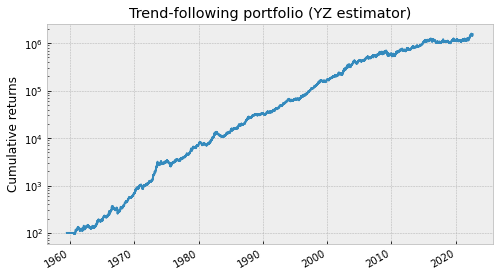

In [10]:
fig, ax = plt.subplots(figsize=(8, 4.5))
engine_vol_eq.plot(ax=ax, logy=True);
ax.set_title('Trend-following portfolio (YZ estimator)')
ax.set_ylabel('Cumulative returns');

In [11]:
engine_vol_eq.pipe(Performance).summary()

,Trend-following portfolio (YZ estimator)
CAGR,0.149602
Annualised vol,0.127283
Sharpe ratio,1.175352
Max drawdown,0.305877
Calmar ratio,0.489092
Skewness,0.280465
Kurtosis,22.101988
Worst return,-0.137043
Worst 1d return,-0.137043
Worst 1w return,-0.098542


## TREND signal

Another improvement BK2020 proposes is to use a continuous signal rather than a binary one in order to reduce the turnover when signals are weak. Specifically they used the t-values with the Newey-West standard error as the signal. They further capped and floored the signal between -1 and +1 to avoid extreme positions.

`statsmodels`'s `OLS` class provides a method to compute the Newey-West standard error. https://www.statsmodels.org/stable/generated/statsmodels.regression.linear_model.OLS.html

In [12]:
engine_trend = BacktestEngine(
    strategy=Strategy.DELTA_ONE.value,
    instrument=all_futures_baltas2020.index,
    signal=signal.ParallelSignal([
        signal.VolatilityScale(agg_method='rolling', window=21, ann_factor=261, 
                               target_volatility=0.4, signal_cap=0.95),
        signal.TSMOMBaltas2020()
    ], weighting='product'),
    weighting=Weighting.EQUAL_WEIGHT.value,
    log_level=logging.WARN,
)
engine_trend.run()

In [13]:
engine_trend_eq = (engine_trend.calculate_equity_curve(calculate_net=False, rebalance_freq='m')
                   .rename('Trend-following portfolio (TREND signal)'))

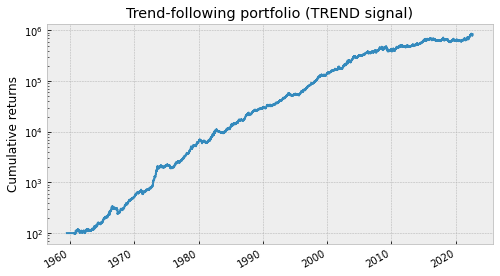

In [14]:
fig, ax = plt.subplots(figsize=(8, 4.5))
engine_trend_eq.plot(ax=ax, logy=True);
ax.set_title('Trend-following portfolio (TREND signal)')
ax.set_ylabel('Cumulative returns');

In [15]:
engine_trend_eq.pipe(Performance).summary()

,Trend-following portfolio (TREND signal)
CAGR,0.139868
Annualised vol,0.107939
Sharpe ratio,1.295803
Max drawdown,0.294584
Calmar ratio,0.474797
Skewness,0.158837
Kurtosis,27.990986
Worst return,-0.121269
Worst 1d return,-0.121269
Worst 1w return,-0.110077


## Combined

Finally we run a backtest by using both the Yang-Zhang volatility estimator and the TREND signal.

In [16]:
engine_combined = BacktestEngine(
    strategy=Strategy.DELTA_ONE.value,
    instrument=all_futures_baltas2020.index,
    signal=signal.ParallelSignal([
        signal.VolatilityScale(volatility_type=RealisedVolatility.YZ.value,
                               agg_method='rolling', window=21, min_periods=10,
                               target_volatility=0.4, signal_cap=0.95, ann_factor=261),
        signal.TSMOMBaltas2020()
    ], weighting='product'),
    weighting=Weighting.EQUAL_WEIGHT.value,
    log_level=logging.WARN,
)
engine_combined.run()

In [17]:
engine_combined_eq = (engine_combined.calculate_equity_curve(calculate_net=False, rebalance_freq='m')
                      .rename('Trend-following portfolio (YZ estimator + TREND signal)'))

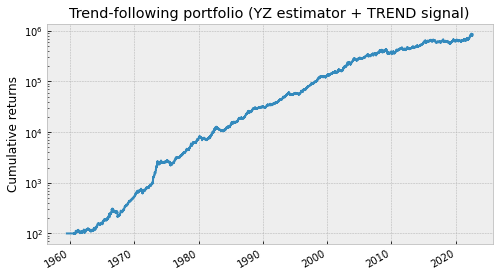

In [18]:
fig, ax = plt.subplots(figsize=(8, 4.5))
engine_combined_eq.plot(ax=ax, logy=True)
ax.set_title('Trend-following portfolio (YZ estimator + TREND signal)')
ax.set_ylabel('Cumulative returns');

In [19]:
engine_combined_eq.pipe(Performance).summary()

,Trend-following portfolio (YZ estimator + TREND signal)
CAGR,0.140319
Annualised vol,0.110672
Sharpe ratio,1.267876
Max drawdown,0.313945
Calmar ratio,0.446953
Skewness,0.292293
Kurtosis,32.511163
Worst return,-0.130152
Worst 1d return,-0.130152
Worst 1w return,-0.112097


# Comparison

In this section we compare the above 4 backtests.

## Performance

As reported in BK2020, using the YZ estimator and TREND signal does not alter the performance characteristics. Rather, the TREND signal somewhat improves the Sharpe ratio. Also the TREND signal lowers the annualised volatility from 12.5% to 10.8% with the close-to-close realised volatility.

In [20]:
performance_comp = pd.concat((engine_original_eq, engine_vol_eq, 
                              engine_trend_eq, engine_combined_eq), axis=1)

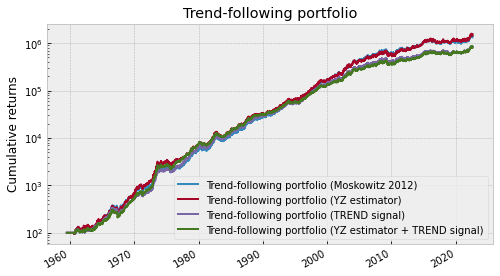

In [21]:
fig, ax = plt.subplots(figsize=(8, 4.5))
performance_comp.plot(ax=ax, logy=True);
ax.set_title('Trend-following portfolio')
ax.set_ylabel('Cumulative returns');

In [22]:
performance_comp.pipe(Performance).summary()

,Trend-following portfolio (Moskowitz 2012),Trend-following portfolio (YZ estimator),Trend-following portfolio (TREND signal),Trend-following portfolio (YZ estimator + TREND signal)
CAGR,0.147960,0.149234,0.139868,0.139974
Annualised vol,0.124997,0.127127,0.107939,0.110537
Sharpe ratio,1.183713,1.173898,1.295803,1.266307
Max drawdown,0.259239,0.305877,0.294584,0.313945
Calmar ratio,0.570749,0.487890,0.474797,0.445855
Skewness,0.073521,0.281378,0.158837,0.293259
Kurtosis,19.320638,22.163243,27.990986,32.597603
Worst return,-0.126276,-0.137043,-0.121269,-0.130152
Worst 1d return,-0.126276,-0.137043,-0.121269,-0.130152
Worst 1w return,-0.107725,-0.098542,-0.110077,-0.112097


## Turnover reduction

Again, as reported in BK2020, both enhancements reduce the turnover significantly while not affecting the performance. The chart below shows the reduction in turnover for each futures contract. By utilising the YZ realised volatility and the TREND signal, overall the turnover is reduced by more than 30%.

In [23]:
engine_original_pos = engine_original.get_position_by_instrument()
engine_vol_pos = engine_vol.get_position_by_instrument()
engine_trend_pos = engine_trend.get_position_by_instrument()
engine_combined_pos = engine_combined.get_position_by_instrument()

In [24]:
engine_original_turnover = (engine_original_pos.diff().abs().mean().mul(261)
                            .rename('Trend-following portfolio (Moskowitz 2012)'))
engine_vol_turnover = (engine_vol_pos.diff().abs().mean().mul(261)
                       .rename('Trend-following portfolio (YZ estimator)'))
engine_trend_turnover = (engine_trend_pos.diff().abs().mean().mul(261)
                         .rename('Trend-following portfolio (TREND signal)'))
engine_combined_turnover = (engine_combined_pos.diff().abs().mean().mul(261)
                            .rename('Trend-following portfolio (YZ estimator + TREND signal)'))

In [25]:
turnover_reduction = (
    pd.concat((engine_vol_turnover, engine_trend_turnover, engine_combined_turnover), axis=1)
    .div(engine_original_turnover, axis=0)
    .sub(1)
    .reindex(index=all_futures_baltas2020.index)
    .rename(index=all_futures_baltas2020['name'])
)

In [26]:
turnover_reduction.mean()

Trend-following portfolio (YZ estimator)                  -0.181320
Trend-following portfolio (TREND signal)                  -0.207458
Trend-following portfolio (YZ estimator + TREND signal)   -0.330933
dtype: float64

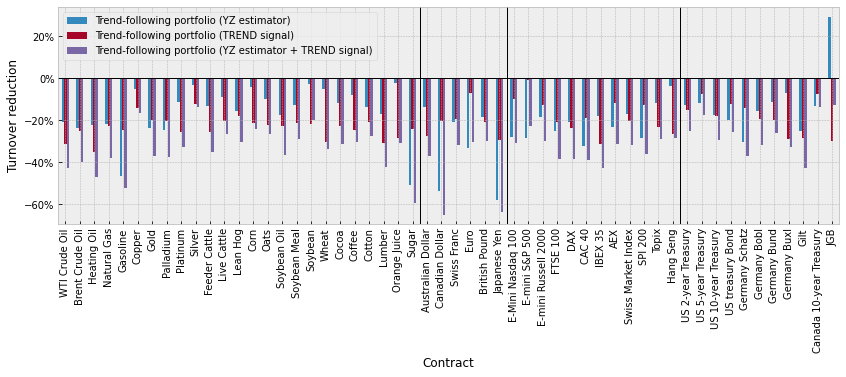

In [27]:
ax = turnover_reduction.plot(kind='bar', figsize=(14, 4))
ax.yaxis.set_major_formatter(mticker.PercentFormatter(1))
ax.axhline(0, color='black', lw=1)
ax.axvline(24.5, color='black', lw=1)
ax.axvline(30.5, color='black', lw=1)
ax.axvline(42.5, color='black', lw=1)
ax.set_xlabel('Contract')
ax.set_ylabel('Turnover reduction');

# Recent performance

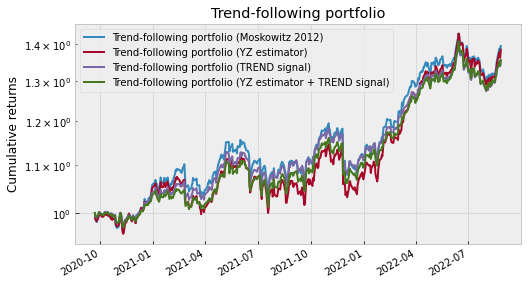

In [28]:
fig, ax = plt.subplots(figsize=(8, 4.5))
performance_comp.tail(252 * 2).pct_change().fillna(0).add(1).cumprod().plot(ax=ax, logy=True);
ax.set_title('Trend-following portfolio')
ax.set_ylabel('Cumulative returns');

# Reference

- Baltas, N. and Kosowski, R., 2020. Demystifying time-series momentum strategies: Volatility estimators, trading rules and pairwise correlations. Market Momentum: Theory and Practice", Wiley.
- Moskowitz, T.J., Ooi, Y.H. and Pedersen, L.H., 2012. Time series momentum. Journal of financial economics, 104(2), pp.228-250.

In [29]:
print(f'Updated: {datetime.utcnow():%d-%b-%Y %H:%M}')

Updated: 28-Aug-2022 07:50
